In [54]:
import os
import re
import sys
import json
import dateutil
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Treeshop Runtime Reads Bytes Correlation

In [55]:
# Find all samples with umend, rnaseq and fusion

rnaseq = [re.findall(r"downstream\/(.*?)\/", path)[0] for path in
         glob.glob("/treehouse/archive/downstream/*/secondary/*rnaseq*/methods.json")]
umend = [re.findall(r"downstream\/(.*?)\/", path)[0] for path in
         glob.glob("/treehouse/archive/downstream/*/secondary/*bam-umend-qc*/methods.json")]
fusion = [re.findall(r"downstream\/(.*?)\/", path)[0] for path in
         glob.glob("/treehouse/archive/downstream/*/secondary/*fusion*/methods.json")]

print("RNASeq: {}, UMEND: {}, Fusion: {}".format(len(rnaseq), len(umend), len(fusion)))

ids = set.intersection(set(rnaseq), set(umend), set(fusion))
print("Intersection: {}".format(len(ids)))

RNASeq: 1432, UMEND: 417, Fusion: 582
Intersection: 408


In [56]:
try:
    # Some files have trailing commands in lists so fixing in ingest
    umend = [json.loads(re.sub(",[ \t\r\n]+\]", "]", open(m).read()))
             for m in glob.glob("/treehouse/archive/downstream/*/secondary/*bam-umend-qc-*/methods.json")]
except:
    print(sys.exc_info()[2].tb_next.tb_frame.f_locals)
    raise

print("UMEND Method IDs Found:", len(umend))

UMEND Method IDs Found: 417


In [57]:
try:
    methods = [{
        "rnaseq": json.loads(open(
            glob.glob("/treehouse/archive/downstream/{}/secondary/*rnaseq*/methods.json"
                      .format(id))[0]).read()),
        "umend": json.loads(open(
            glob.glob("/treehouse/archive/downstream/{}/secondary/*umend*/methods.json"
                      .format(id))[0]).read()),
        "fusion": json.loads(open(
            glob.glob("/treehouse/archive/downstream/{}/secondary/*fusion*/methods.json"
                      .format(id))[0]).read())
    } for id in ids]
except:
    print(sys.exc_info()[2].tb_next.tb_frame.f_locals)
    raise

In [58]:
runtimes = pd.DataFrame([{
    "sample_id": m["rnaseq"]["sample_id"],
    "size":
        sum([os.path.getsize(os.path.join("/treehouse/archive", i)) for i in m["rnaseq"]["inputs"] 
             if os.path.exists(os.path.join("/treehouse/archive", i))]) / 10**9,
    "runtime":
        sum([(dateutil.parser.parse(v["end"])
              - dateutil.parser.parse(v["start"])).total_seconds()/(60*60) for k,v in m.items()]),
        
} for m in methods])

In [59]:
runtimes_with_size = runtimes[runtimes["size"] > 0]

In [60]:
runtimes_with_size.shape

(233, 3)

In [61]:
runtimes_with_size.loc[runtimes["size"].idxmax()]

runtime             64.5166
sample_id    THR33_0990_S01
size                50.9308
Name: 327, dtype: object

In [62]:
runtimes_with_size.mean()["runtime"]

17.704693442477346

In [63]:
runtimes_with_size.median()["size"]

18.302538786

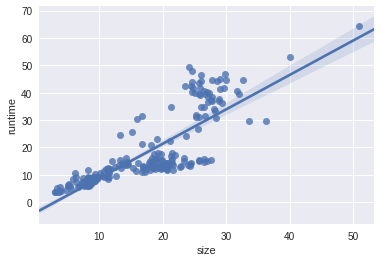

In [64]:
sns.regplot(x="size", y="runtime", data=runtimes_with_size)

In [65]:
linear = np.polyfit(runtimes_with_size["size"].values, runtimes_with_size["runtime"].values, deg=1)
print("hours / gigabyte", linear[0])

hours / gigabyte 1.2558015805805025


In [47]:
runtimes_with_size.describe()

,runtime,size
count,233.000000,233.000000
mean,17.704693,17.098948
std,12.788485,8.382327
min,3.622332,2.988922
25%,8.636684,8.756552
50%,13.218096,18.302539
75%,21.296318,24.057976
max,64.516609,50.930828


## CBTTC Cavatica AWS

In [124]:
manifest = pd.read_csv("/home/jovyan/cbttc_manifest.csv")

In [126]:
manifest.head()

,id,name,project,race,gender,vital_status,ethnicity,platform_unit_id,disease_type,sample_id,...,Sequencing Coverage,sample_uuid,aliquot_id,Insert Size,reference_genome,case_id,Sequencing Center,days_to_death,experimental_strategy,quality_scale
0,5b117f4eec70d7f4d3fbad06,11bd481c-4cd1-4b2a-9e13-1b4aba7cd4d2.bam,cavatica/pgdn-821z,Black or African American,Male,Alive,Not Hispanic or Latino,NaN,Low-grade glioma/astrocytoma (WHO grade I/II),7316-162-T,...,100M,bbc6af81-7211-4b59-9f1f-887378a671ea,564459,250,HG19,C35670,NANT,NaN,RNA-Seq,illumina18
1,5b117f4eec70d7f4d3fbacfa,17556e26-ea02-41f5-8b74-b11c2dbd8af8.bam,cavatica/pgdn-821z,White,Female,Alive,Unavailable/Not Reported,NaN,Low-grade glioma/astrocytoma (WHO grade I/II),7316-235-T,...,100M,837d3acc-535d-4b6a-88eb-020d580be578,564458,250,HG19,C17835,NANT,NaN,RNA-Seq,illumina18
2,5b117f4eec70d7f4d3fbad17,1ef7f947-f77b-42db-850f-1838b7e2aaa6.bam,cavatica/pgdn-821z,White,Male,Alive,Not Hispanic or Latino,NaN,Medulloblastoma,7316-1801-T,...,100M,fef276af-a186-44e2-b2ea-5d5bde52f1c4,564481,250,HG19,C478962,NANT,NaN,RNA-Seq,illumina18
3,5b117f4eec70d7f4d3fbacc2,1e1e8a2d-d746-4c92-97d4-22cf3bc48392.bam,cavatica/pgdn-821z,White,Male,Alive,Not Hispanic or Latino,NaN,Ependymoma,7316-443-T,...,100M,cf8d5c32-5c9e-426c-9197-dbdbc756af1a,571398,250,HG19,C91881,NANT,NaN,RNA-Seq,illumina18
4,5b117f4eec70d7f4d3fbad39,01999899-8431-40b3-9976-27d8ba17e2e6.local.tra...,cavatica/pgdn-821z,White,Female,Deceased-due to disease,Not Hispanic or Latino,NaN,High-grade glioma/astrocytoma (WHO grade III/IV),7316-1068-T,...,100M,02048579-6ee2-427d-b479-50995526125f,574556,250,RefSeq_Build_73,C191019,NANT,155.0,RNA-Seq,illumina18


In [127]:
manifest[manifest.sample_id == "7316-162-T"]

,id,name,project,race,gender,vital_status,ethnicity,platform_unit_id,disease_type,sample_id,...,Sequencing Coverage,sample_uuid,aliquot_id,Insert Size,reference_genome,case_id,Sequencing Center,days_to_death,experimental_strategy,quality_scale
0,5b117f4eec70d7f4d3fbad06,11bd481c-4cd1-4b2a-9e13-1b4aba7cd4d2.bam,cavatica/pgdn-821z,Black or African American,Male,Alive,Not Hispanic or Latino,NaN,Low-grade glioma/astrocytoma (WHO grade I/II),7316-162-T,...,100M,bbc6af81-7211-4b59-9f1f-887378a671ea,564459,250,HG19,C35670,NANT,NaN,RNA-Seq,illumina18
60,5b117f4eec70d7f4d3fbaea5,11bd481c-4cd1-4b2a-9e13-1b4aba7cd4d2.local.tra...,cavatica/pgdn-821z,Black or African American,Male,Alive,Not Hispanic or Latino,NaN,Low-grade glioma/astrocytoma (WHO grade I/II),7316-162-T,...,100M,d1ed4af4-3976-410e-b3b8-afa532db2d7c,564459,250,RefSeq_Build_73,C35670,NANT,NaN,RNA-Seq,illumina18


In [128]:
with open("/home/jovyan/cbttc_download_links.txt") as f:
    links = f.readlines()
print(len(links))

692


In [ ]:
import requests
files = {}
for link in links:
    r = requests.get(link.strip(), headers={"Range": "bytes=0-0"})
    files[r.headers["Content-Disposition"].split("=")[1]] = {"size": int(r.headers["Content-Range"].split("/")[1])}

In [141]:
sum([v["size"] for k,v in files.items() if "local.transcript" not in k]) / 1000**3

5708.470868718

In [148]:
sizes = pd.DataFrame(files).T

In [149]:
sizes.head()

,size
008f259f-c6a4-49a1-b404-efe16afb3a8a.bam,17870146049
008f259f-c6a4-49a1-b404-efe16afb3a8a.local.transcript.bam,32404519671
01999899-8431-40b3-9976-27d8ba17e2e6.bam,18811399367
01999899-8431-40b3-9976-27d8ba17e2e6.local.transcript.bam,34767985605
019c8219-31e2-4bcb-8801-d8248f17040b.bam,20189446457


In [154]:
sum(sizes["size"].values)

14077521254526

In [157]:
pd.merge(manifest, sizes, how="left", left_on="name", right_index=True).to_csv(
    "/home/jovyan/cbttc_manifest_with_size.tsv", sep="\t")

## St Judes PCGP

In [6]:
manifest = pd.read_csv("/home/jovyan/stjude_manifest.tsv", sep="\t")
manifest.head()

,file_path,subject_name,sample_name,sample_type,sequencing_type,file_type,description,sj_diseases,sj_datasets,sj_pmid_accessions,sj_ega_accessions
0,/restricted/BAM/SJRHB002_G.WholeGenome.bam.bai,SJRHB002,SJRHB002_G,Germline,WGS,BAM,NaN,RHB,Pediatric Cancer Genome Project (PCGP),"23232254,24332040",EGAS00001000256
1,/restricted/BAM/SJRHB002_G.WholeGenome.bam,SJRHB002,SJRHB002_G,Germline,WGS,BAM,NaN,RHB,Pediatric Cancer Genome Project (PCGP),"23232254,24332040",EGAS00001000256
2,/restricted/BAM/SJRHB005_G.WholeGenome.bam,SJRHB005,SJRHB005_G,Germline,WGS,BAM,NaN,RHB,Pediatric Cancer Genome Project (PCGP),"23232254,24332040",EGAS00001000256
3,/restricted/BAM/SJRHB005_G.WholeGenome.bam.bai,SJRHB005,SJRHB005_G,Germline,WGS,BAM,NaN,RHB,Pediatric Cancer Genome Project (PCGP),"23232254,24332040",EGAS00001000256
4,/restricted/BAM/SJRB051_G.WholeGenome.bam.bai,SJRB051,SJRB051_G,Germline,WGS,BAM,NaN,RB,Pediatric Cancer Genome Project (PCGP),NaN,NaN


In [39]:
rnaseq = manifest[manifest.sequencing_type == "RNA-Seq"]
print("RNASeq:", rnaseq.shape[0])
PCGP = rnaseq[rnaseq.sj_datasets == "Pediatric Cancer Genome Project (PCGP)"]
print("PCGP:", PCGP.shape[0])
print("File Types:", set(PCGP.file_type))

RNASeq: 1794
PCGP: 1794
File Types: {'BAM'}
